The target of this project is to build models for pharmacokinetics (PK) parameter prediction. Data was collected from [Drug Metab Dispos 46:1466–1477, November 2018](https://dmd.aspetjournals.org/content/suppl/2018/08/16/dmd.118.082966.DC1).

In this notebook I'll do the exploratory data analysis. Aims:
- Data understanding
- Establish preprocessing methods for packaging

Strategy: Examine X, Y variables columns and info columns. Determine strategy of preprocessing for each column.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import missingno
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
import chembl_structure_pipeline

RDKit WARNING: [09:47:00] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
rawdf = pd.read_excel("data/Supplemental_82966_revised_corrected.xlsx", header=8)

In [3]:
rawdf.head()

,Name,CAS #,SMILES,human VDss (L/kg),human CL (mL/min/kg),fraction unbound \nin plasma (fu),MRT (h),terminal t1/2 (h),Reference,Comments,Notes,Year of first disclosure,MW,HBA,HBD,TPSA_NO,RotBondCount,moka_ionState7.4,MoKa.LogP,MoKa.LogD7.4
0,α-hANP,85637-73-6,N1[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(...,0.20,25.40,NaN,0.13,0.22,"Nakao, K.; Sugawara, A.; Morii, N.; Sakamoto, ...",α-Human Atrial Natriuretic Peptide. MRT calcul...,NaN,1982,3080.44,84,53,1403.4,75,cationic,-9.00,-9.00
1,(-)dOTC,160707-69-7,c1cn(c(=O)nc1N)[C@H]2CO[C@H](S2)CO,1.18,3.00,NaN,6.50,19.20,"PATRICK F. SMITH, ALAN FORREST, CHARLES H. BAL...",Dosed as 100 mg of racemate. (-) form called a...,NaN,1994,229.26,6,2,90.4,2,neutral,-1.90,-1.90
2,(+)dOTC,160707-68-6,c1cn(c(=O)nc1N)[C@@H]2CO[C@@H](S2)CO,0.84,3.90,NaN,3.60,8.92,"PATRICK F. SMITH, ALAN FORREST, CHARLES H. BAL...",Dosed as 100 mg of racemate. (-) form called a...,NaN,1994,229.26,6,2,90.4,2,neutral,-1.90,-1.90
3,"1,3-DCQA",19870-46-3,O[C@@H]1C[C@@](C[C@@H](OC(=O)\C=C\c2ccc(O)c(O)...,0.79,8.70,NaN,1.50,1.37,"Wen-Zheng Ju,Yang Zhao,Fang Liu,Ting Wua,Jun Z...","1,3-dicaffeoylquinic acid. Data digitized from...",NaN,1964,516.45,12,7,211.3,9,anionic,2.10,-1.60
4,16-acetyl gitoxin,7242-07-1,C1([C@@H]2[C@@]3([C@@]([C@@H]4[C@@H]([C@@]5(CC...,0.78,0.18,0.07,72.30,51.60,"Hausten, K.-O. On the Pharmacokinetics of 16-A...","16-O-acetylgitoxin. N=6, 65.3 kg average weigh...",NaN,1960,822.98,15,5,209.1,9,neutral,0.93,0.93


## Data validation

#### Duplication check

In [4]:
rawdf.apply(lambda s: s.duplicated().any())

Name                                 False
CAS #                                False
SMILES                                True
human VDss (L/kg)                     True
human CL (mL/min/kg)                  True
fraction unbound \nin plasma (fu)     True
MRT (h)                               True
terminal  t1/2 (h)                    True
Reference                             True
Comments                              True
Notes                                 True
Year of first disclosure              True
MW                                    True
HBA                                   True
HBD                                   True
TPSA_NO                               True
RotBondCount                          True
moka_ionState7.4                      True
MoKa.LogP                             True
MoKa.LogD7.4                          True
dtype: bool

SMILES has duplication. Let the duplication.

In [5]:
rawdf.loc[rawdf.SMILES.duplicated(keep=False), ]

,Name,CAS #,SMILES,human VDss (L/kg),human CL (mL/min/kg),fraction unbound \nin plasma (fu),MRT (h),terminal t1/2 (h),Reference,Comments,Notes,Year of first disclosure,MW,HBA,HBD,TPSA_NO,RotBondCount,moka_ionState7.4,MoKa.LogP,MoKa.LogD7.4
550,Gadofosveset,742680-48-4,C(C([N+]([Gd+++]([N+]1(C2)C3)([N+](C2)(C2)C4)(...,0.15,0.10,0.16,22.7,16.30,PDR Accessed on March 15 2013. http://www.pdr3...,0.03 mmol/kg dose. VDss from MRT and clearance.,PDR Accessed on March 15 2013. http://www.pdr3...,2014,679.73,14,0,151.1,4,NaN,NaN,NaN
554,Gadoxetate,770677-60-6,C(C([N+]([Gd+++]([N+]1(C2)C3)([N+](C2)(C2)C4)(...,0.21,3.57,0.90,1.0,0.95,PDR accessed March 15 2013 http://www.pdr3d.co...,VDss from MRT and clearance. Ppb < 10%. CAS n...,NaN,2009,679.73,14,0,151.1,4,NaN,NaN,NaN


Different PK parameters, but the computed physiochemical values are same. 

In [6]:
[sm for sm in rawdf.loc[rawdf.SMILES.duplicated(keep=False), "SMILES"]]

['C(C([N+]([Gd+++]([N+]1(C2)C3)([N+](C2)(C2)C4)([O-]5)([O-]6)([O-]C3=O)([O-]C4=O)[O-]C2=O)(CC6=O)CC5=O)C1)C(=CC=C1OCC)C=C1',
 'C(C([N+]([Gd+++]([N+]1(C2)C3)([N+](C2)(C2)C4)([O-]5)([O-]6)([O-]C3=O)([O-]C4=O)[O-]C2=O)(CC6=O)CC5=O)C1)C(=CC=C1OCC)C=C1']

Check the structures.

RDKit ERROR: [09:47:01] SMILES Parse Error: syntax error while parsing: C(C([N+]([Gd+++]([N+]1(C2)C3)([N+](C2)(C2)C4)([O-]5)([O-]6)([O-]C3=O)([O-]C4=O)[O-]C2=O)(CC6=O)CC5=O)C1)C(=CC=C1OCC)C=C1
RDKit ERROR: [09:47:01] SMILES Parse Error: Failed parsing SMILES 'C(C([N+]([Gd+++]([N+]1(C2)C3)([N+](C2)(C2)C4)([O-]5)([O-]6)([O-]C3=O)([O-]C4=O)[O-]C2=O)(CC6=O)CC5=O)C1)C(=CC=C1OCC)C=C1' for input: 'C(C([N+]([Gd+++]([N+]1(C2)C3)([N+](C2)(C2)C4)([O-]5)([O-]6)([O-]C3=O)([O-]C4=O)[O-]C2=O)(CC6=O)CC5=O)C1)C(=CC=C1OCC)C=C1'
RDKit ERROR: [09:47:01] SMILES Parse Error: syntax error while parsing: C(C([N+]([Gd+++]([N+]1(C2)C3)([N+](C2)(C2)C4)([O-]5)([O-]6)([O-]C3=O)([O-]C4=O)[O-]C2=O)(CC6=O)CC5=O)C1)C(=CC=C1OCC)C=C1
RDKit ERROR: [09:47:01] SMILES Parse Error: Failed parsing SMILES 'C(C([N+]([Gd+++]([N+]1(C2)C3)([N+](C2)(C2)C4)([O-]5)([O-]6)([O-]C3=O)([O-]C4=O)[O-]C2=O)(CC6=O)CC5=O)C1)C(=CC=C1OCC)C=C1' for input: 'C(C([N+]([Gd+++]([N+]1(C2)C3)([N+](C2)(C2)C4)([O-]5)([O-]6)([O-]C3=O)([O-]C4=O)[O-]C2=O)(C

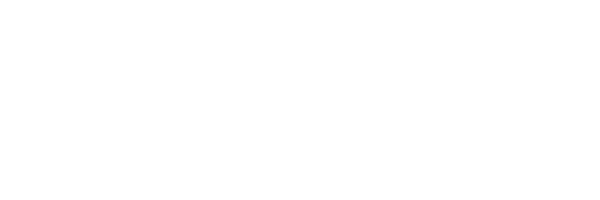

In [7]:
Draw.MolsToGridImage([Chem.MolFromSmiles(sm) for sm in rawdf.loc[rawdf.SMILES.duplicated(keep=False), "SMILES"]])

There's syntax error in the SMILES, should drop these 2 rows.

In [8]:
df = rawdf.loc[~rawdf.SMILES.duplicated(keep=False), ]
df.shape

(1350, 20)

#### SMILES sanity check

Systematically check the SMILES representation.

In [9]:
def is_valid_smiles(sm):
    try:
        Chem.SanitizeMol(Chem.MolFromSmiles(sm))
    except:
        return False
    else:
        return True

In [10]:
df.SMILES.apply(is_valid_smiles).value_counts()

RDKit ERROR: [09:47:01] Explicit valence for atom # 3 O, 3, is greater than permitted
RDKit ERROR: [09:47:02] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [09:47:02] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [09:47:02] Explicit valence for atom # 3 O, 3, is greater than permitted
RDKit ERROR: [09:47:02] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [09:47:02] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [09:47:02] Explicit valence for atom # 6 O, 3, is greater than permitted
RDKit ERROR: [09:47:02] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [09:47:02] Explicit valence for atom # 9 O, 3, is greater than permitted
RDKit ERROR: [09:47:02] Explicit valence for atom # 21 Cl, 2, is greater than permitted


True     1340
False      10
Name: SMILES, dtype: int64

Examine the invalid smiles records.

In [11]:
df.loc[~df.SMILES.apply(is_valid_smiles), ]

RDKit ERROR: [09:47:02] Explicit valence for atom # 3 O, 3, is greater than permitted
RDKit ERROR: [09:47:02] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [09:47:02] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [09:47:02] Explicit valence for atom # 3 O, 3, is greater than permitted
RDKit ERROR: [09:47:02] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [09:47:02] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [09:47:02] Explicit valence for atom # 6 O, 3, is greater than permitted
RDKit ERROR: [09:47:03] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [09:47:03] Explicit valence for atom # 9 O, 3, is greater than permitted
RDKit ERROR: [09:47:03] Explicit valence for atom # 21 Cl, 2, is greater than permitted


,Name,CAS #,SMILES,human VDss (L/kg),human CL (mL/min/kg),fraction unbound \nin plasma (fu),MRT (h),terminal t1/2 (h),Reference,Comments,Notes,Year of first disclosure,MW,HBA,HBD,TPSA_NO,RotBondCount,moka_ionState7.4,MoKa.LogP,MoKa.LogD7.4
195,Carboplatin,41575-94-4,N[Pt+2]1(N)[O-]C(=O)C2(CCC2)C(=O)[O-]1,0.26,1.50,1.00,3.00,2.00,"Elferink F, van der Vijgh WJ, Klein I, Vermork...",Used 1.6 m2 = 60 kg since the study was done i...,NaN,1982,369.24,6,2,108.8,0,NaN,NaN,NaN
547,Gadobenate,113662-23-0,[N]1(CC(=O)[O-])([Gd+3]2[N@@](CC1)(CC[N@@]2([C...,0.21,1.60,1.00,2.20,1.81,Gadobenate Dimeglumine - FDA Approval Package\...,"N=4, 0.3 mmol/kgh dose. MRT from VDss and cler...",Gadobenate Dimeglumine - FDA Approval Package\...,1988,665.71,14,0,209.9,14,NaN,NaN,NaN
548,Gadobutrol,770691-21-9,[Gd+3]1234567OC([C@@H](CO)[N]81CC[N]4(CC[N]3(C...,0.22,2.00,1.00,1.80,1.30,Gadobutrol - FDA Approval Package\nClinical Ph...,"N=24, doses from 0.05 to 0.4 mmol/kg averaged ...",Gadobutrol - FDA Approval Package\nClinical Ph...,1991,603.70,13,2,134.8,2,NaN,NaN,NaN
549,Gadodiamide,131410-48-5,CNC1=O[Gd+3]234567N(CCN2(C1)CC(=O)[O-]3)(CCN4(...,0.20,1.79,NaN,1.85,1.46,"van Wagoner, M., O'Toole, M., Worah, D., Leese...",DV7572. Omniscan. Renal clearance 98% of total...,NaN,1990,576.68,13,5,131.8,0,NaN,NaN,NaN
551,Gadopentetate,80529-93-7,O=C1C[N]23CC[N]45CC(=O)[O-][Gd+3]2424([O-]1)([...,0.27,1.94,1.00,2.30,1.60,PDR Accessed March 15 2013 http://www.pdr3d.co...,VDss from MRT and clearance.,PDR Accessed March 15 2013. http://www.pdr3d.c...,1982,545.56,13,0,141.9,0,NaN,NaN,NaN
552,Gadoteridol,120066-54-8,[N]123CC[N]45CC[N]67CC[N]8(CC1)CC(=O)[O-][Gd+3...,0.20,1.50,NaN,2.20,1.60,PDR accessed August 08 2013 http://www.pdr3d.c...,VDss from MRT and clearance.,http://www.pdr3d.com/detail.php?c=49389#section-4,1988,558.68,11,1,97.9,0,NaN,NaN,NaN
553,Gadoversetamide,131069-91-5,COCCNC1=O[Gd+3]234567O=C(CN2(CCN3(CCN4(CC(=O)[...,0.16,1.20,1.00,2.20,1.70,OptiMARK Product Label.,NaN,NaN,1990,664.79,15,5,150.2,6,NaN,NaN,NaN
829,Molsidomine,25717-80-0,[n+]1(N2CCOCC2)cc([NH-]C(OCC)=O)on1,1.40,11.00,1.00,2.10,1.60,"J. Ostrowski, and K. Resag, Pharmacokinetics o...",70 kg assumed. 2 mg dose iv. N not reported.,95% radioactivity recovered with only 2% uncha...,1969,243.24,8,1,84.6,4,neutral,-2.3,-2.3
916,Oxaliplatin,61825-94-3,C1CC[C@H]2[C@H](C1)N[Pt+2]3(N2)[O-]C(=O)C(=O)[...,0.50,0.10,0.13,82.80,58.92,"Jing Liu, Eric Kraut, Jonathan Bender, Rebecca...",Eloxatin. NSC 266046. Total plasma Pt data fro...,NaN,1976,395.28,6,2,80.8,0,NaN,NaN,NaN
1256,Toxogonin,114-90-9,[n+]1(ccc(\C=N\O)cc1)COC[n+]1ccc(\C=N\O)cc1.[C...,0.17,1.90,NaN,1.50,1.20,Toxogonin and Pralidoxime: Kinetic Comparison ...,Obidoxime. CAS number refers to chloride salt....,NaN,1963,361.22,7,2,82.2,6,neutral,-9.0,-9.0


Since the invalid SMILES are less than 1%, we can safely remove them.

In [12]:
df = df.loc[df.SMILES.apply(is_valid_smiles), ]

RDKit ERROR: [09:48:14] Explicit valence for atom # 3 O, 3, is greater than permitted
RDKit ERROR: [09:48:14] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [09:48:14] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [09:48:14] Explicit valence for atom # 3 O, 3, is greater than permitted
RDKit ERROR: [09:48:14] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [09:48:14] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [09:48:14] Explicit valence for atom # 6 O, 3, is greater than permitted
RDKit ERROR: [09:48:14] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [09:48:14] Explicit valence for atom # 9 O, 3, is greater than permitted
RDKit ERROR: [09:48:14] Explicit valence for atom # 21 Cl, 2, is greater than permitted


In [13]:
df.shape

(1340, 20)

#### Missingness

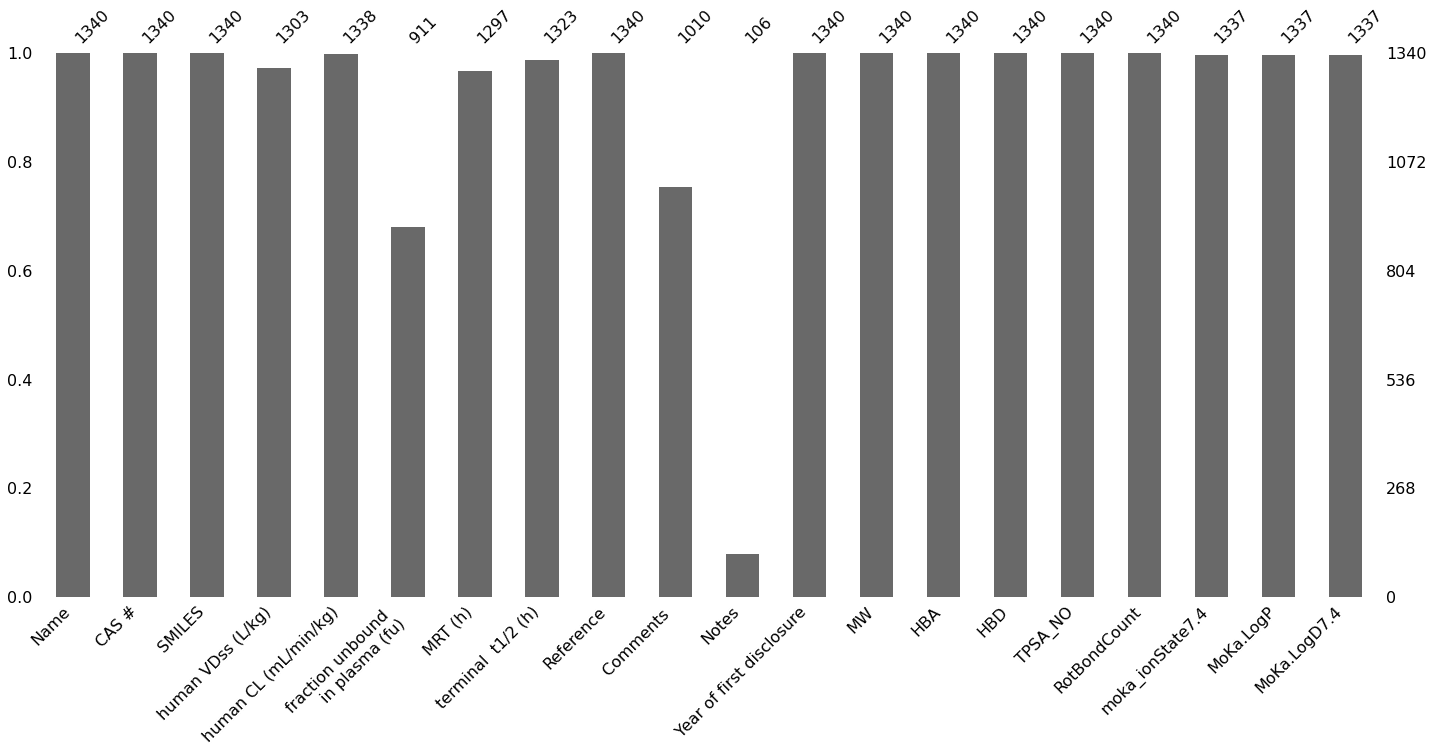

In [14]:
missingno.bar(df)

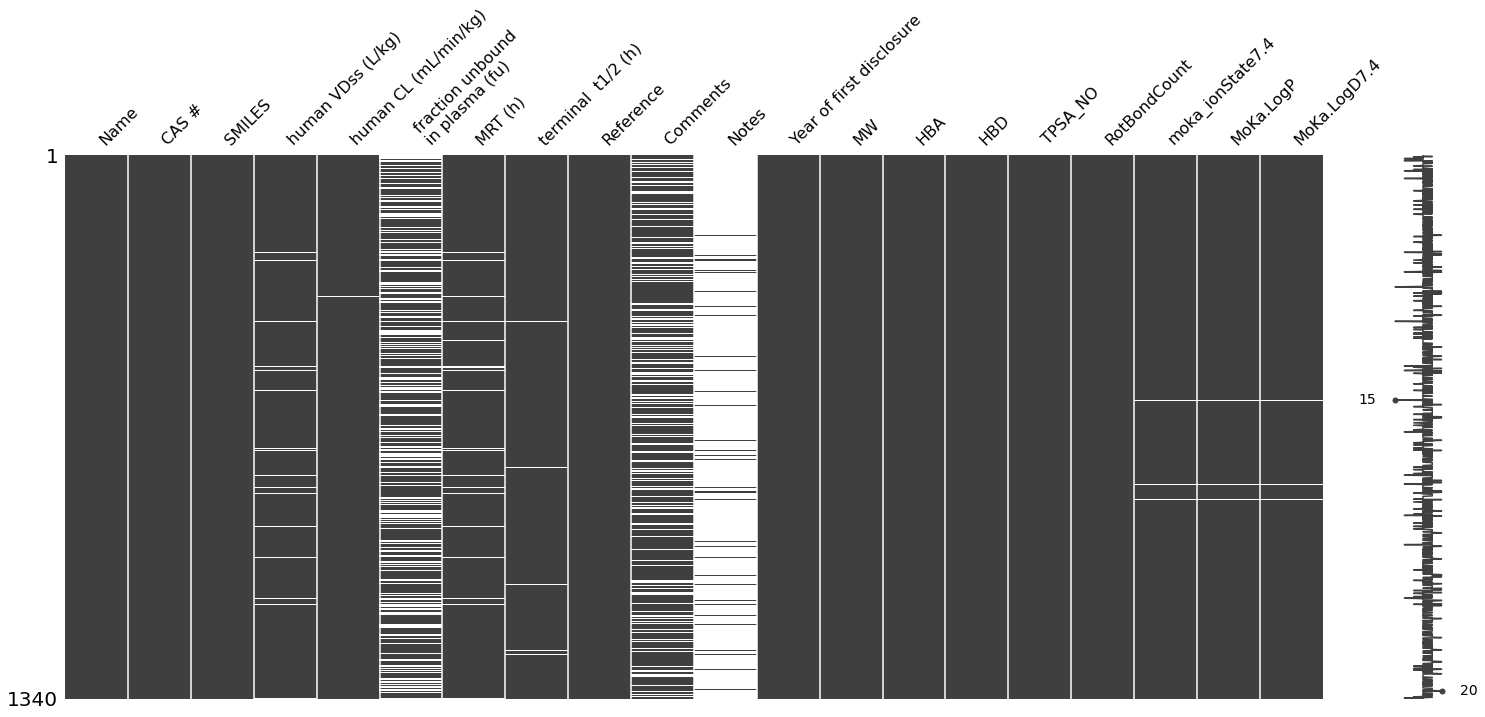

In [15]:
missingno.matrix(df)

According to the article, MoKa software cannot calculate these missing due to:
> "either relatively large molecules (e.g., mipomersen,MW7150 Da) or the presence of metal ions (e.g., Gd or Pt) in the compounds"

Consider dropping them in the first round of modeling for easy processing?

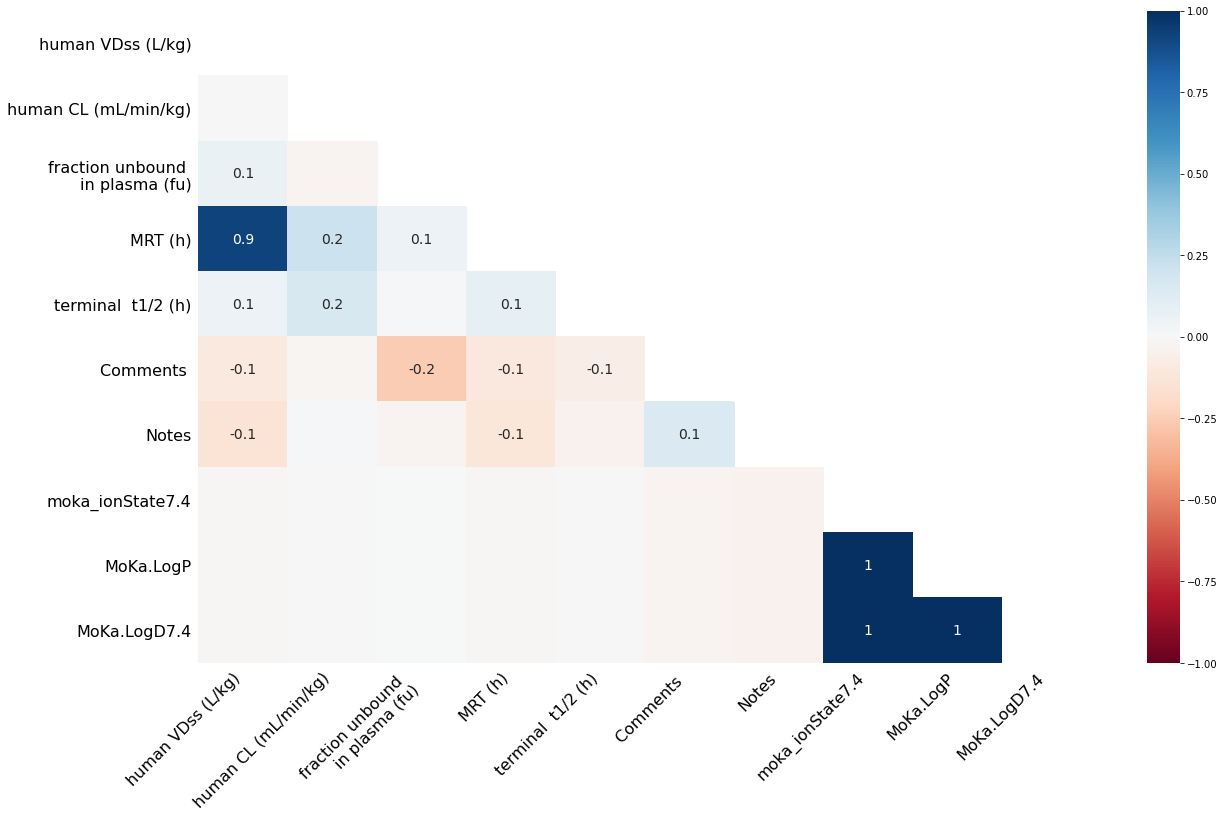

In [16]:
missingno.heatmap(df)

Missningness seems not a big deal. We just need to use the intersection according to target to predict.

#### Molecule structure inspection

Take several rounds of eye-inspection incase there are unspotted issues.

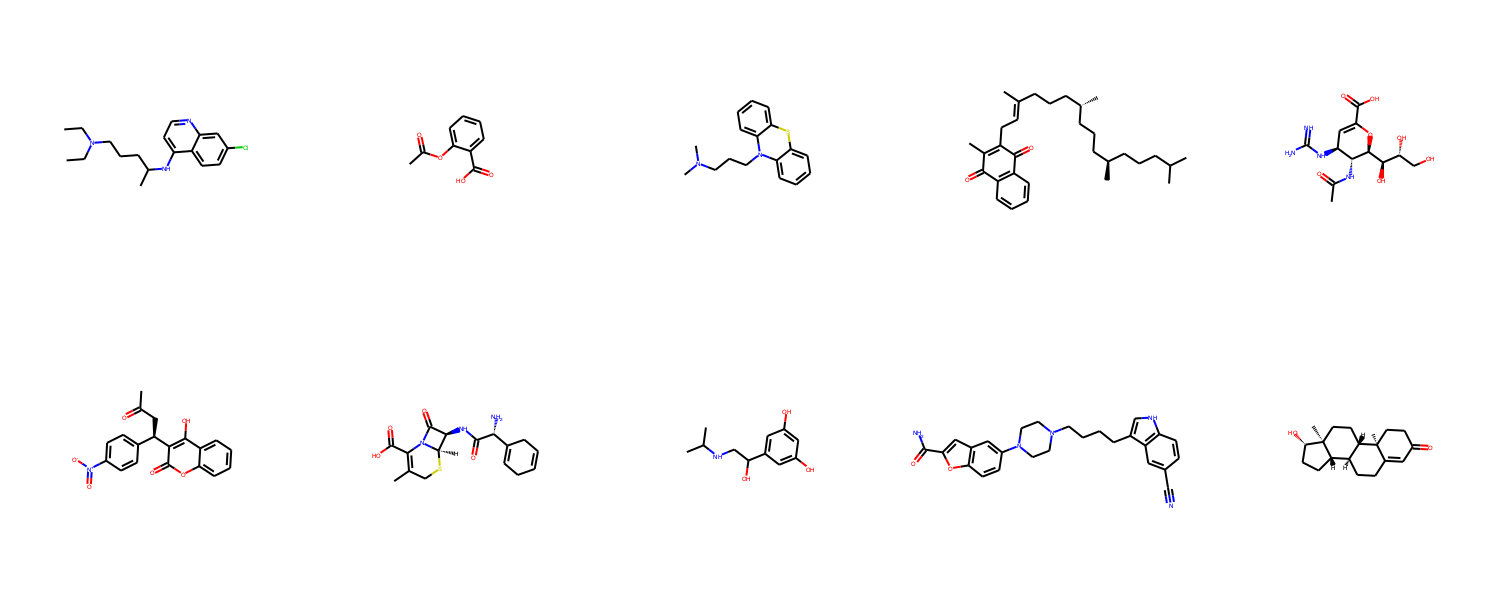

In [17]:
n_batch_inspect = 10
Draw.MolsToGridImage(
    [Chem.MolFromSmiles(sm) for sm in df.SMILES.sample(n_batch_inspect) if is_valid_smiles(sm)], 
    molsPerRow=5, subImgSize=(300, 300)
)

## X variables

X variables are the computed physiochemical values. They can be used to predict PK parameters and also as Y for fine-tuning GNN (considering time this might not be probable). 

In [18]:
df.columns

Index(['Name', 'CAS #', 'SMILES', 'human VDss (L/kg)', 'human CL (mL/min/kg)',
       'fraction unbound \nin plasma (fu)', 'MRT (h)', 'terminal  t1/2 (h)',
       'Reference', 'Comments ', 'Notes', 'Year of first disclosure', 'MW',
       'HBA', 'HBD', 'TPSA_NO', 'RotBondCount', 'moka_ionState7.4',
       'MoKa.LogP', 'MoKa.LogD7.4'],
      dtype='object')

In [19]:
x_cols = [
    'MW', 'HBA', 'HBD', 'TPSA_NO', 'RotBondCount', 
    'moka_ionState7.4', 'MoKa.LogP', 'MoKa.LogD7.4'
]

### Numerical X

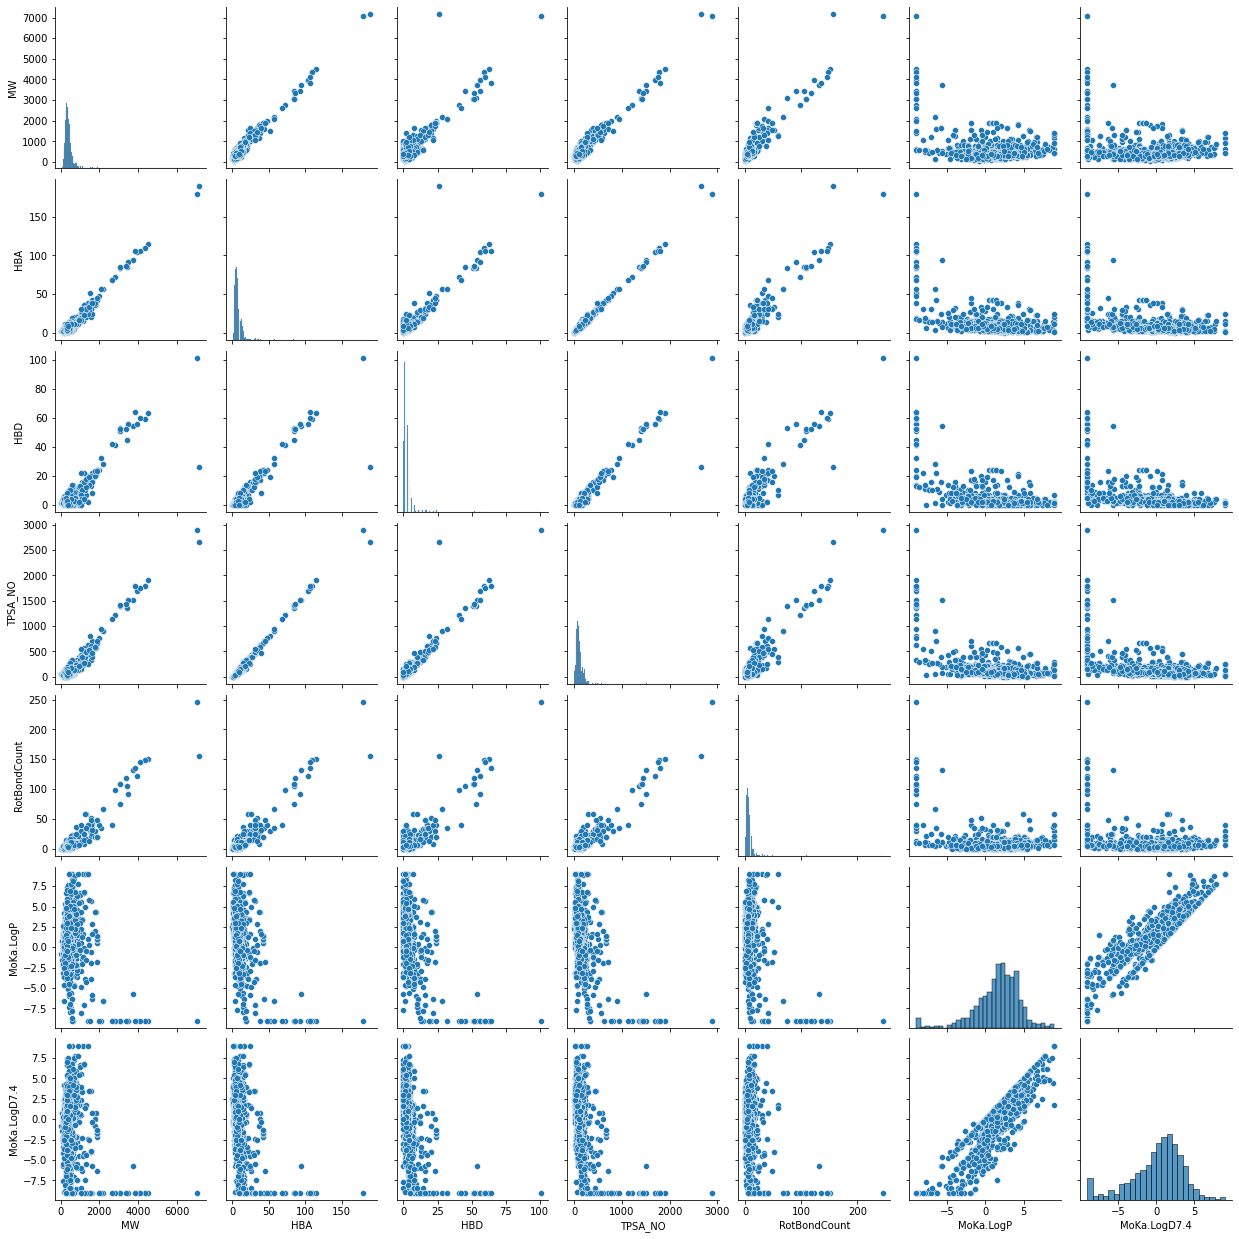

In [20]:
sns.pairplot(df[x_cols])

A pairplot examination on numeric X variables can tell us that the distribution is right-skewed or extreme values exist except in the last 2 variables.

#### Extreme value

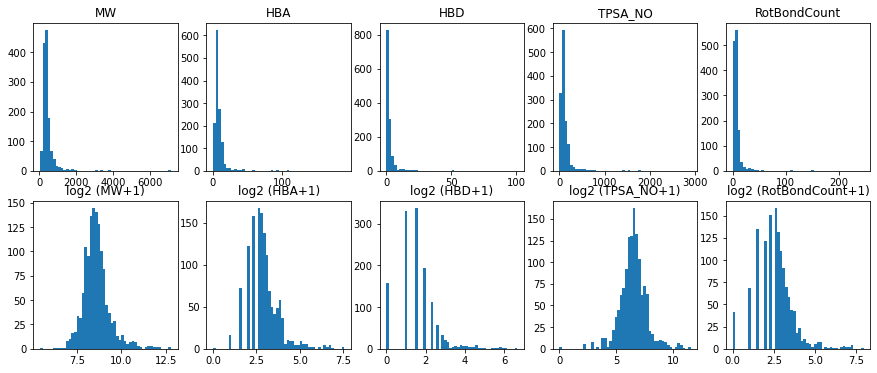

In [34]:
plt.figure(figsize=(15, 6))
for i,colname in enumerate(x_cols[:5]):
    plt.subplot(2, 5, i+1)
    plt.hist(df[colname], bins=50)
    plt.title(colname)
    plt.subplot(2, 5, i+6)
    plt.hist(np.log2(df[colname]+1), bins=50)
    plt.title(f'log2 ({colname}+1)')

Molecular weight, TPSA_NO are right-skewed can be transformed by log2(val+1).  
HBA, HBD and RBC have extreme values and should be upper-clipped and min-max scaled. Let's set the upper bound empirically to 90% percentile + 1: HBA - 15, HBD - 7, RBC - 13.

In [22]:
for colname in ('HBA', 'HBD', 'RotBondCount'):
    print(f"{colname} upper-bound: {np.percentile(df[colname], 90) + 1}")

HBA upper-bound: 15.0
HBD upper-bound: 7.0
RotBondCount upper-bound: 13.0


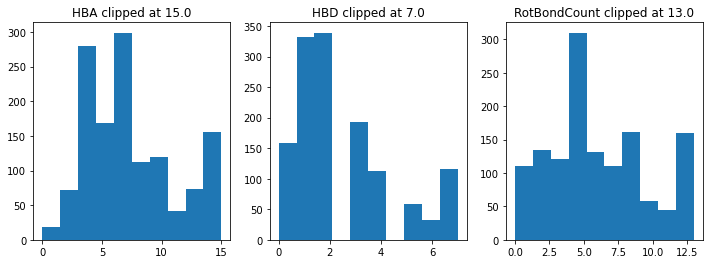

In [23]:
plt.figure(figsize=(12, 4))
for i, colname in enumerate(('HBA', 'HBD', 'RotBondCount')):
    plt.subplot(1, 3, i+1)
    upper_bound = np.percentile(df[colname], 90) + 1
    plt.title(f"{colname} clipped at {upper_bound}")
    plt.hist(df[colname].apply(lambda ele: ele if ele < upper_bound else upper_bound))

### Categorical X

The only categorical X is 'moka_ionState7.4'.

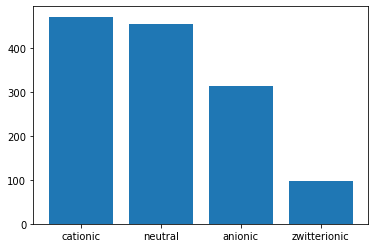

In [24]:
plt.bar(x=df['moka_ionState7.4'].value_counts().index, height=df['moka_ionState7.4'].value_counts())
plt.show()

Simply one-hot encode this variable is sufficient.

### (opt) Feature engineering

Future feature engineering should be supported by domain experts. One possible feature could be normalization by MW since MW is positively related with those counted variables.

### X strategy summary

- Standard scale
    - 'MoKa.LogP', 'MoKa.LogD7.4'
- Upper-clipping & min-max scale
    - 'HBA', 'HBD', 'RotBondCount'
- Log2(value+1) & standard scale
    - 'MW', 'TPSA_NO'
- One-hot encoding
    - 'moka_ionState7.4'
    
Note that MOKA related features have missing values in raw data.  
Note that public data can also be used to suppliment prediction as long as no leakage. 

## Y variables

Y variables are the PK parameters. Beside the parameters in raw data, there can be 2 additional PK parameters mentioned in the literature, free VD and free CL. In this project we only need to predict 2 PK parameters, VDss and CL. Let's take a look on all Y variables first.

In [25]:
y_cols = [
    'human VDss (L/kg)', 'human CL (mL/min/kg)',
    'fraction unbound \nin plasma (fu)', 'MRT (h)', 'terminal  t1/2 (h)'
]

In [26]:
y_df = df.loc[:, y_cols]
y_df['VDss_u'] = y_df['human VDss (L/kg)'] / y_df['fraction unbound \nin plasma (fu)']
y_df['CLp_u'] = y_df['human CL (mL/min/kg)'] / y_df['fraction unbound \nin plasma (fu)']

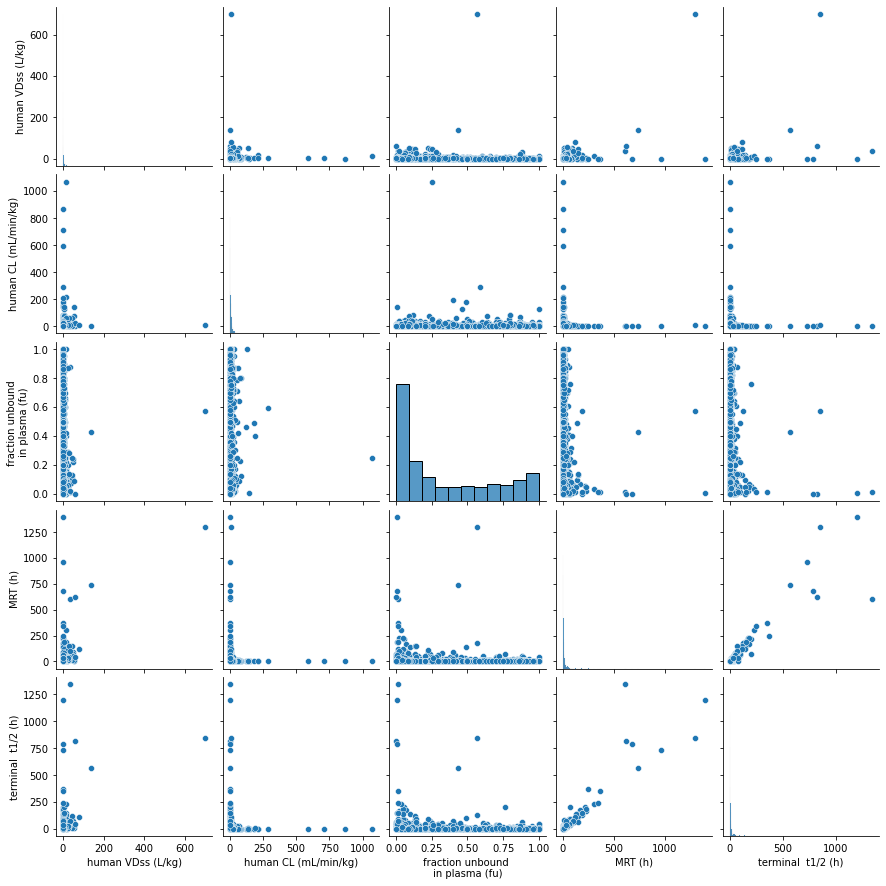

In [27]:
sns.pairplot(y_df[y_cols])
plt.show()

Correlation comes from 2 time dependent variables: MRT (mean residence time) and t1/2.

After checking the literature, extreme values are valid assay results, not error-caused outliers. Let's see how to transform them. According to project requirement, use log2 for transformation.

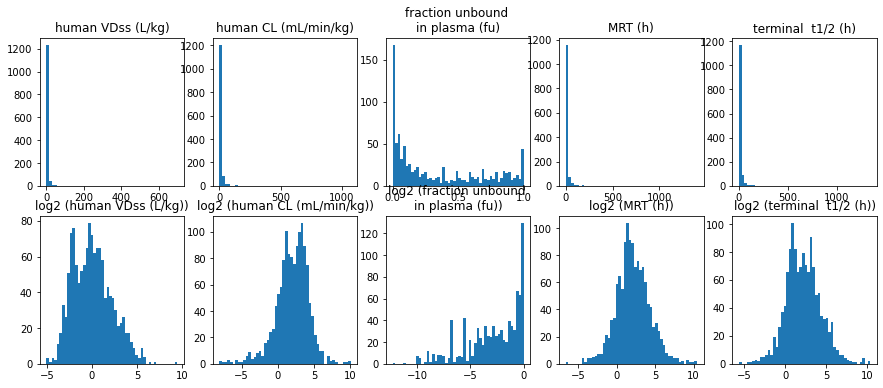

In [29]:
plt.figure(figsize=(15, 6))
for i,colname in enumerate(y_cols):
    plt.subplot(2, 5, i+1)
    plt.hist(df[colname], bins=50)
    plt.title(colname)
    plt.subplot(2, 5, i+6)
    plt.hist(np.log2(df[colname]), bins=50)
    plt.title(f'log2 ({colname})')

Log2 is a good transformation for all Y variables except fu. Center of the log values should not be a problem as they can be adjusted by pre-initiated bias.  
Although the distribution is right-skewed, for fu we don't need any transformation since its range is already in 0-1.  
Now Let's check the 2 additional PK parameters: free VD and free CL.

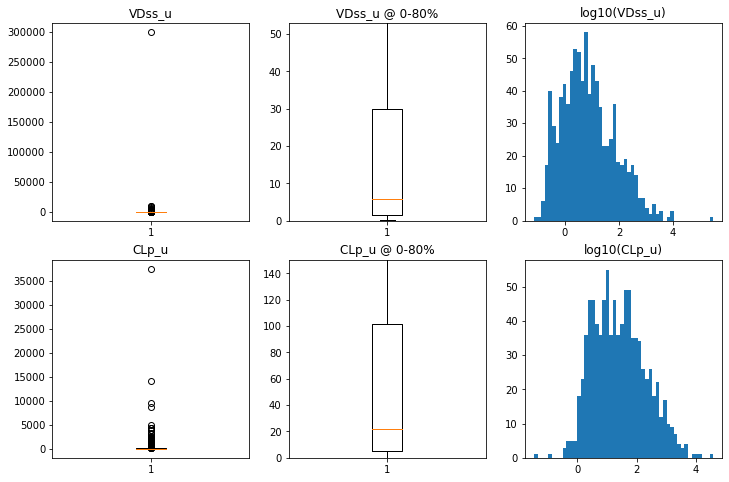

In [30]:
plt.figure(figsize=(12, 8))
for i, colname in enumerate(("VDss_u", "CLp_u")):
    vals = y_df[colname].dropna()
    plt.subplot(2, 3, i*3+1)
    plt.boxplot(vals)
    plt.title(colname)
    plt.subplot(2, 3, i*3+2)
    plt.title(colname)
    plt.boxplot(vals)
    plt.ylim(
        0, 
        round(np.percentile(vals, 80)), 
    )
    plt.title(f"{colname} @ 0-80%")
    plt.subplot(2, 3, i*3+3)
    plt.hist(np.log10(vals), bins=50)
    plt.title(f"log10({colname})")
plt.show()

From the missingness examination we know data size for VDss and CL are different. Be cautious when preprocessing or exploring multi-tasking.

---

## Touch-base QA

Before modeling we had a QA session to touch base, here's the question list:

- Q: Background story?  
A: Make model for PK prediction on VDss and CLp (log2 transform as required). Others PK parameters not required. Time-split: Using historical data (year of first disclosure <2000) as train-val, year of first disclosure >=2000 as test set.
- Q: What makes a good prediction in this case?  
A: Metrics: Pearson-correlation & MAE. Generalization is important as **the model(s) will be tested in other in-house datasets**.
- Q: Regression or classification? If classification, is there any pre-defined cutoff?  
A: Regression on 
- Q: free-VDss and free-CLp, also target to predict? Then whatabout fu?  
A: Only predict VDss and CL. No need to predict others.
- Q: Requirement on model interpretability?  
A: Not required for this case. But model design rationale should be presented.
- Q: measurement change with time?  
A: Possible. Need to check the distribution between train and test.

Data validation issues:
- 2 identical SMILES & 10 invalid SMILES: safe to dump.

4 Deliverables by Aug20:
- Model performance metrics & visualization: Pearson's correlation, MAE. Y variable: log2(VDss), log2(CL)
- Tabel on predicted PK for test compounds。
- Reproducible: Packaged model and codes. Better share the github repo.
- PPT: present the project, model design rationale.

Tech requirements:
- PyTorch for deep learning
- AutoML can be used to tune hyperparameters but not for model structure
- Ensemble is not allowed. Must be single model
- Public data incorporation allowed as long as not creating leaking.

After exploration we can proceed to setup pre-processing methods.

---
## Scratchpad


In [32]:
df[["human VDss (L/kg)", "human CL (mL/min/kg)"]].applymap(np.log2)

,human VDss (L/kg),human CL (mL/min/kg)
0,-2.321928,4.666757
1,0.238787,1.584963
2,-0.251539,1.963474
3,-0.340075,3.121015
4,-0.358454,-2.473931
...,...,...
1347,-2.395929,2.405992
1348,0.765535,4.392317
1349,0.378512,1.722466
1350,NaN,4.459432


In [33]:
df[["human VDss (L/kg)", "human CL (mL/min/kg)"]]

,human VDss (L/kg),human CL (mL/min/kg)
0,0.20,25.40
1,1.18,3.00
2,0.84,3.90
3,0.79,8.70
4,0.78,0.18
...,...,...
1347,0.19,5.30
1348,1.70,21.00
1349,1.30,3.30
1350,NaN,22.00
